# Treatment of uncomplicated UTIs in primary care

### Obtaining data from BigQuery

In [1]:
#import libraries required for analysis
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import  DateFormatter
import datetime
import matplotlib.gridspec as gridspec
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

In [31]:
projectid = "ebmdatalab"
#obtain long term trends data for trimethoprim and nitrofurantoin
lt_overall_df = pd.read_gbq("""
SELECT
year, 
  SUM(CASE
      WHEN chemical = 'Trimethoprim' THEN items
      ELSE 0 END) AS trimethoprim_items,
  SUM(CASE
      WHEN chemical = 'Nitrofurantoin' THEN items
      ELSE 0 END) AS nitrofurantoin_items
FROM
  `ebmdatalab.richard.trimethoprim_pca`
GROUP BY
year
  """, projectid, dialect='standard')
lt_overall_df.to_csv('lt_overall_df.csv')

Requesting query... ok.
Job ID: job_YCyyMzhyz98i7qCRAptjM018HuI5
Query running...
Query done.
Cache hit.

Retrieving results...
Got 20 rows.

Total time taken 1.21 s.
Finished at 2018-06-01 11:20:24.


In [32]:
#obtain overall data for prescribing for trimethoprim capsules at CCG level
ccg_df = pd.read_gbq("""
SELECT
  trimethoprim.month as period,
  trimethoprim.pct,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
      ELSE 0 END) AS trimethoprim_items,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501130R0' THEN items
      ELSE 0 END) AS nitrofurantoin_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items)) AS trimethoprim_percent
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
and trimethoprim.month  >='2011-01-01 00:00:00'
GROUP BY
  period,
  pct
ORDER BY
  period,
  pct
""", projectid, dialect='standard')
ccg_df.to_csv('ccg_df.csv')

Requesting query... ok.
Job ID: job_v_1wkQZu-qumsXUSxGDzAY0ee59K
Query running...
Query done.
Cache hit.

Retrieving results...
Got 17316 rows.

Total time taken 5.43 s.
Finished at 2018-06-01 11:21:49.


In [33]:
#obtain overall data for prescribing for trimethoprim at practice level where practices with list size of => 1000
practice_df = pd.read_gbq("""
SELECT
  trimethoprim.month as period,
  trimethoprim.practice,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
      ELSE 0 END) AS trimethoprim_items,
  SUM(CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501130R0' THEN items
      ELSE 0 END) AS nitrofurantoin_items,
  SUM(items) AS all_items,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items)) AS trimethoprim_percent
FROM
  ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.practice_statistics_all_years AS listsize
ON
  trimethoprim.practice=listsize.practice
AND   
  trimethoprim.month=listsize.month
WHERE
  listsize.total_list_size >=1000
  and trimethoprim.month >='2011-01-01 00:00:00'
GROUP BY
  period,
  practice
ORDER BY
  period,
  practice
""", projectid, dialect='standard')
practice_df.to_csv('practice_df.csv')

Requesting query... ok.
Job ID: job_uhz_wH7je-3bA2WsMyJQ1ZihIBpX
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 18% done. Elapsed 10.93 s.
  Got page: 3; 27% done. Elapsed 15.85 s.
  Got page: 4; 36% done. Elapsed 20.53 s.
  Got page: 5; 45% done. Elapsed 25.27 s.
  Got page: 6; 54% done. Elapsed 30.3 s.
  Got page: 7; 63% done. Elapsed 35.41 s.
  Got page: 8; 72% done. Elapsed 50.24 s.
  Got page: 9; 81% done. Elapsed 56.28 s.
  Got page: 10; 90% done. Elapsed 61.1 s.
  Got page: 11; 99% done. Elapsed 65.49 s.
  Got page: 12; 100% done. Elapsed 66.18 s.
Got 645524 rows.

Total time taken 113.75 s.
Finished at 2018-06-01 11:24:06.


## Create stacked bar charts

### Long-term trend bar chart

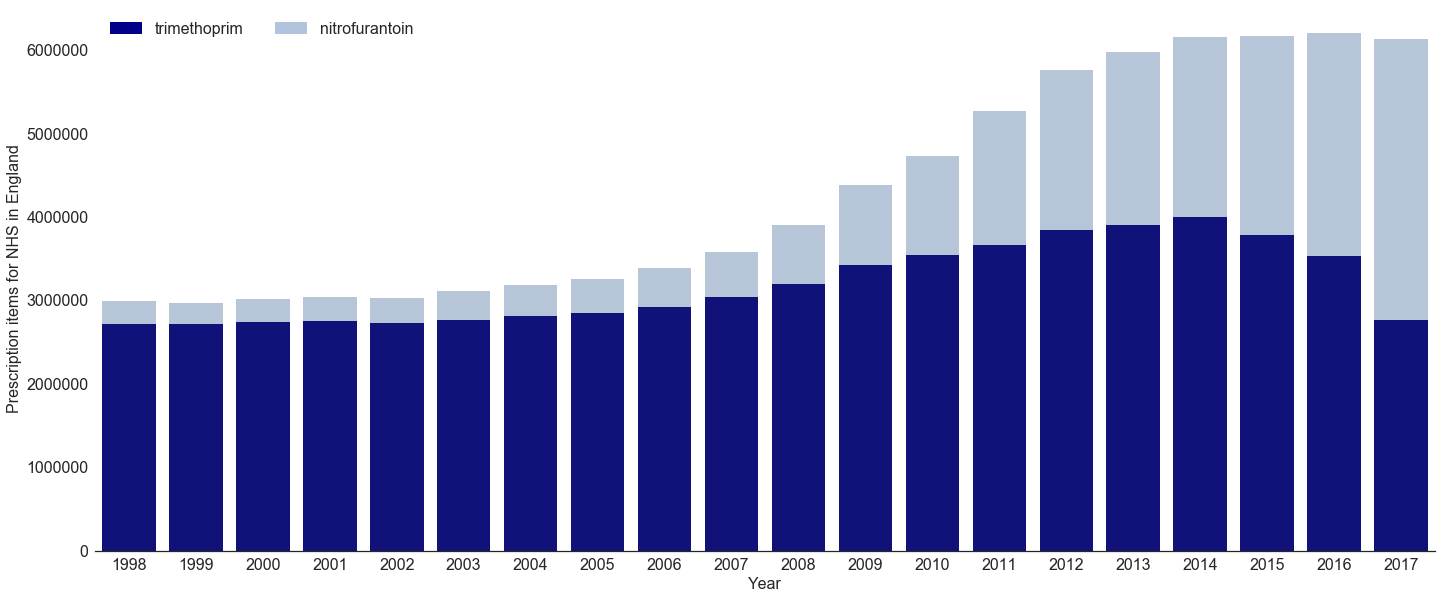

In [22]:
#Create additional columns for bar stacks
lt_overall_df['all_items']=lt_overall_df['trimethoprim_items']+lt_overall_df['nitrofurantoin_items']

#Create stacked graph in Seaborn, using overlaid plots

#setup style and size
sns.set_style("white")
sns.set_context({"figure.figsize": (24, 10)})

#plot chart
#top_plot - "all_items"  - will show "nitrofurantoin" in final plot
top_plot = sns.barplot(x="year", y="all_items",data=lt_overall_df,color = "lightsteelblue", ci=None)
#bottom_plot - "trimethoprim_items"
bottom_plot = sns.barplot(x="year", y="trimethoprim_items",data=lt_overall_df, color = "darkblue", ci=None)

#create legend
topbar = plt.Rectangle((0,0),1,1,fc="lightsteelblue", edgecolor = 'none')
bottombar = plt.Rectangle((0,0),1,1,fc='darkblue',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['trimethoprim', 'nitrofurantoin'], loc=0, ncol = 32, prop={'size':16})
l.draw_frame(False)

#format axes
sns.despine(left=True)
bottom_plot.set_ylabel("Prescription items for NHS in England")
bottom_plot.set_xlabel("Year")
for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] +
             bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)
    
#plt.savefig('Figure 1.png', format='png', dpi=300)

### Create timeseries for CCGs and practice deciles of percentage of UTI prescribing as trimethoprim

In [6]:
#create deciles for practices
x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))
practice_deciles = practice_df.groupby('period')['trimethoprim_percent'].quantile(x)
practice_deciles_df=pd.DataFrame(practice_deciles)
practice_deciles_df=practice_deciles_df.reset_index()
# create integer range of percentiles as integers are better for  charts
practice_deciles_df["index"] = (practice_deciles_df.level_1*100).map(int)
practice_deciles_df['period'] = practice_deciles_df['period'].astype(str)
# set format for dates:
practice_deciles_df['period'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in practice_deciles_df['period']]

#create deciles for CCGs
x1 = np.arange(0.1, 1, 0.1)
x2 = np.arange(0.01,0.1,0.01)
x3 = np.arange(0.91, 1, 0.01)
x = np.concatenate((x1,x2,x3))
ccg_deciles = ccg_df.groupby('period')['trimethoprim_percent'].quantile(x)
ccg_deciles_df=pd.DataFrame(ccg_deciles)
ccg_deciles_df=ccg_deciles_df.reset_index()
# create integer range of percentiles as integers are better for  charts
ccg_deciles_df["index"] = (ccg_deciles_df.level_1*100).map(int)
ccg_deciles_df['period'] = ccg_deciles_df['period'].astype(str)
# set format for dates:
ccg_deciles_df['period'] = [datetime.datetime.strptime(date, '%Y-%m-%d').date() for date in ccg_deciles_df['period']]

In [7]:
ccg_deciles_df.head(200)

,period,level_1,trimethoprim_percent,index
0,2011-01-01,0.10,0.665407,10
1,2011-01-01,0.20,0.696558,20
2,2011-01-01,0.30,0.716353,30
3,2011-01-01,0.40,0.728022,40
4,2011-01-01,0.50,0.744191,50
5,2011-01-01,0.60,0.757898,60
6,2011-01-01,0.70,0.782857,70
7,2011-01-01,0.80,0.798483,80
8,2011-01-01,0.90,0.822694,90
9,2011-01-01,0.01,0.534004,1


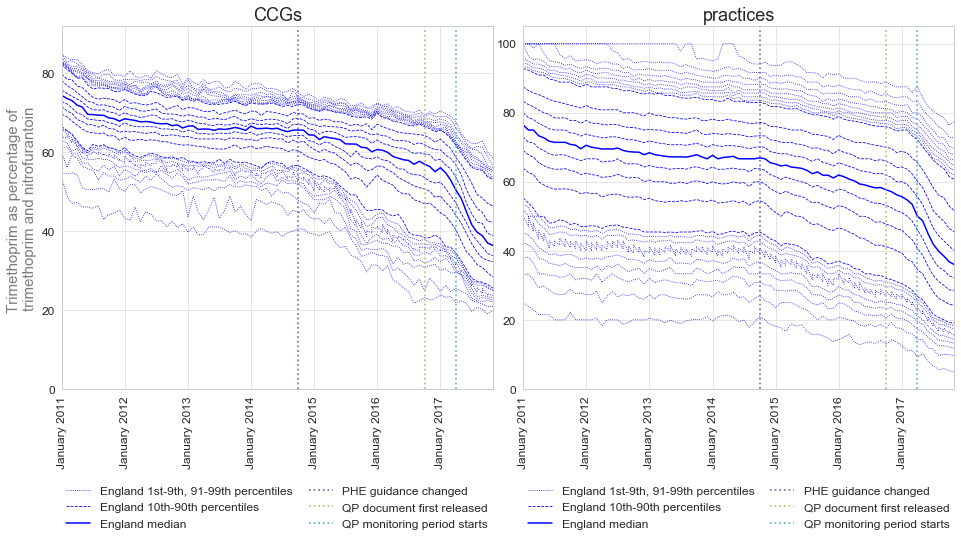

In [30]:
# Plot time series charts of deciles
sns.set_style("whitegrid",{'grid.color': '.9'})
fig = plt.figure(figsize=(16,6.666)) 
gs = gridspec.GridSpec(1,2)  # grid layout for subplots

# set sort order of drugs manually, and add grid refs to position each subplot:
s = [(0,ccg_deciles_df,0,0,'CCGs'), (1,practice_deciles_df,0,1,'practices')]

# Plot each subplot using a loop
for i in s:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s (, sharey=ax)
    for decile in range(1,99):   # plot each decile line
        data = i[1].loc[(i[1]['index']==decile)]
        if decile == 50:
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b-',linewidth=1.5, label='England median')
        if decile == 10:
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b--',linewidth=0.8,label='England 10th-90th percentiles') 
        if (decile == 1) :
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b:',linewidth=0.8, label='England 1st-9th, 91-99th percentiles')
        if ((decile <10) and (decile >1)) | (decile >90):
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b:',linewidth=0.8, label='_nolegend_')
        if (decile >10) and (decile <91) and (decile !=50):
            ax.plot(data["period"],100*data['trimethoprim_percent'],'b--',linewidth=0.8, label='_nolegend_') 
    if  i[3]%2==0:    # set y axis title only for charts in leftmost column
        ax.set_ylabel('Trimethoprim as percentage of \ntrimethoprim and nitrofurantoin', size =15, alpha=0.6)
        
       
    ax.set_title(i[4],size = 18)
    ax.set_ylim([0, 100*i[1]['trimethoprim_percent'].max()*1.05])  # set ymax across all subplots as largest value across dataset
    ax.tick_params(labelsize=12)
    ax.set_xlim([i[1]['period'].min(), i[1]['period'].max()]) # set x axis range as full date range
    ax.axvline(x='2014-10-01',label='PHE guidance changed', linestyle=':', color='C3')
    ax.axvline(x='2016-10-01',label='QP document first released', linestyle=':', color='C4')
    ax.axvline(x='2017-04-01',label='QP monitoring period starts', linestyle=':', color='C5')

    plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
    ax.legend(bbox_to_anchor=(0., -.4, 1., .102), loc=8,
       ncol=2, mode="expand", fontsize=12, borderaxespad=0.)

    
plt.subplots_adjust(wspace = 0.07,hspace = 0.15)
plt.savefig('Figure 1.png', format='png', dpi=300,bbox_inches='tight')
plt.show()

In [9]:
#create IDR for practices and CCGs
ccg_idr_df=ccg_deciles_df.pivot(index='period', columns='level_1', values='trimethoprim_percent')
ccg_idr_df = ccg_idr_df.rename(columns={0.1:"one",0.9:"nine"})
ccg_idr_df["IDR"] = ccg_idr_df['nine'] - ccg_idr_df['one']
ccg_idr_df = ccg_idr_df.reset_index()

practice_idr_df=practice_deciles_df.pivot(index='period', columns='level_1', values='trimethoprim_percent')
practice_idr_df = practice_idr_df.rename(columns={0.1:"one",0.9:"nine"})
practice_idr_df["IDR"] = practice_idr_df['nine'] - practice_idr_df['one']
practice_idr_df=practice_idr_df.reset_index()


In [10]:
ccg_idr_df.head(60)


level_1,period,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,IDR
0,2011-01-01,0.534004,0.548223,0.600010,0.612102,0.629140,0.637388,0.638672,0.659029,0.662186,...,0.824573,0.826113,0.829410,0.830037,0.831608,0.838827,0.847237,0.850494,0.874910,0.157286
1,2011-02-01,0.489240,0.544692,0.561203,0.613486,0.623576,0.636422,0.643686,0.647034,0.652717,...,0.814197,0.814868,0.816460,0.818923,0.822257,0.824765,0.828577,0.838130,0.865114,0.154518
2,2011-03-01,0.470381,0.547987,0.593053,0.595585,0.602271,0.623772,0.634262,0.635476,0.644891,...,0.801947,0.804485,0.806923,0.808320,0.812628,0.817814,0.832184,0.834783,0.858311,0.154944
3,2011-04-01,0.472363,0.542092,0.583813,0.596038,0.608662,0.613769,0.615321,0.618871,0.624643,...,0.788657,0.790657,0.803595,0.807704,0.811413,0.817809,0.824404,0.835467,0.860241,0.159245
4,2011-05-01,0.460923,0.509059,0.563012,0.572481,0.585790,0.596756,0.604983,0.608480,0.610598,...,0.791212,0.795725,0.798140,0.801854,0.806958,0.810451,0.815091,0.822267,0.842323,0.175837
5,2011-06-01,0.461122,0.504664,0.558994,0.572492,0.581717,0.587196,0.593235,0.596917,0.599057,...,0.775941,0.786055,0.786747,0.787890,0.793508,0.799331,0.802827,0.806328,0.826618,0.166617
6,2011-07-01,0.457458,0.505113,0.553193,0.557818,0.581041,0.597445,0.603308,0.608826,0.613697,...,0.768631,0.772525,0.776309,0.779294,0.782495,0.787837,0.797906,0.801984,0.815985,0.140161
7,2011-08-01,0.464526,0.507006,0.529821,0.551964,0.584464,0.594451,0.599681,0.605068,0.609181,...,0.767561,0.770361,0.773550,0.776880,0.781872,0.787335,0.788651,0.798782,0.814770,0.148135
8,2011-09-01,0.429608,0.507946,0.547881,0.567090,0.581688,0.592285,0.596130,0.610296,0.615950,...,0.769092,0.771239,0.772633,0.776022,0.780679,0.784946,0.797266,0.807165,0.825157,0.143046
9,2011-10-01,0.441777,0.498715,0.539546,0.555398,0.580702,0.588309,0.595185,0.605889,0.609856,...,0.764092,0.765593,0.767438,0.770554,0.775091,0.779729,0.797212,0.809332,0.823718,0.149566


In [11]:
practice_idr_df.head(60)

level_1,period,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,IDR
0,2011-01-01,0.250000,0.329457,0.378373,0.424242,0.454545,0.481481,0.500000,0.520661,0.535354,...,0.934783,0.944444,0.958333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.375000
1,2011-02-01,0.238590,0.333333,0.381787,0.416667,0.444444,0.470967,0.500000,0.500000,0.525727,...,0.931034,0.940585,0.950000,0.963545,1.000000,1.000000,1.000000,1.000000,1.000000,0.384615
2,2011-03-01,0.228901,0.315789,0.363636,0.406568,0.431707,0.456522,0.480000,0.500000,0.500000,...,0.923077,0.930915,0.941176,0.954545,0.987500,1.000000,1.000000,1.000000,1.000000,0.392857
3,2011-04-01,0.215476,0.292683,0.333333,0.379310,0.409091,0.434211,0.458333,0.478261,0.500000,...,0.918250,0.928571,0.941176,0.956522,1.000000,1.000000,1.000000,1.000000,1.000000,0.409091
4,2011-05-01,0.214814,0.298216,0.333333,0.375000,0.400000,0.428571,0.450980,0.466667,0.483670,...,0.916667,0.925239,0.935484,0.948718,0.971548,1.000000,1.000000,1.000000,1.000000,0.409091
5,2011-06-01,0.214274,0.285714,0.329077,0.363636,0.388889,0.407407,0.428571,0.447599,0.466667,...,0.906977,0.914286,0.923077,0.933333,0.951278,1.000000,1.000000,1.000000,1.000000,0.417750
6,2011-07-01,0.200000,0.276552,0.329099,0.360741,0.391304,0.412611,0.428571,0.449532,0.466667,...,0.901833,0.913043,0.923077,0.933333,0.947368,1.000000,1.000000,1.000000,1.000000,0.411774
7,2011-08-01,0.200037,0.272727,0.322581,0.357143,0.385341,0.416667,0.437500,0.454545,0.472290,...,0.900000,0.909091,0.916667,0.933279,0.944444,0.969697,1.000000,1.000000,1.000000,0.398949
8,2011-09-01,0.200000,0.274510,0.325407,0.363636,0.388889,0.411134,0.434903,0.453333,0.470588,...,0.898716,0.906250,0.916667,0.925926,0.937500,0.956522,1.000000,1.000000,1.000000,0.402908
9,2011-10-01,0.222222,0.288806,0.333333,0.355880,0.390244,0.409052,0.428571,0.444444,0.461538,...,0.894737,0.903226,0.913238,0.928571,0.941176,0.965517,1.000000,1.000000,1.000000,0.412698


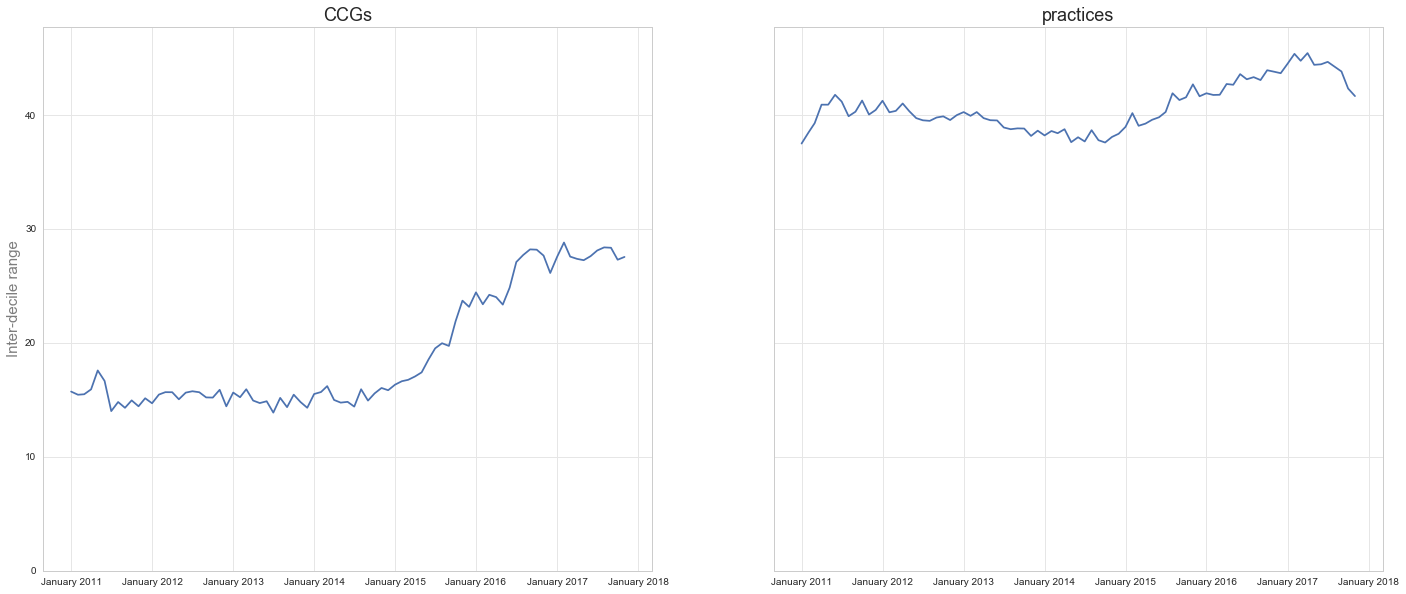

In [27]:
# Plot time series charts of deciles
sns.set_style("whitegrid",{'grid.color': '.9'})
fig = plt.figure(figsize=(16,6.666)) 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(ccg_idr_df["period"], 100*ccg_idr_df["IDR"], linestyle= "solid")
ax2.plot(practice_idr_df["period"], 100*practice_idr_df["IDR"], linestyle= "solid")
ax1.set_title("CCGs",size = 18)
ax2.set_title("practices",size = 18)
ax1.set_ylim([0, 100*practice_idr_df["IDR"].max()*1.05])  # set ymax across all subplots as largest value across dataset
ax.tick_params(labelsize=18)
#ax.set_xlim([i[1]['period'].min(), i[1]['period'].max()]) # set x axis range as full date range
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))
ax1.set_ylabel('Inter-decile range', size =15, alpha=0.6)

plt.savefig('Figure 2.png', format='png', dpi=300,bbox_inches='tight')

In [34]:
#obtain overall data for prescribing for trimethoprim before amended PHE guidance
ccg_pre_df = pd.read_gbq("""
SELECT
  trimethoprim.pct,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items))*100 AS trimethoprim_percent
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
and (trimethoprim.month >='2014-04-01 00:00:00' and trimethoprim.month <= '2014-09-01 00:00:00')
GROUP BY
  pct
ORDER BY
  pct
""", projectid, dialect='standard')
ccg_pre_df.to_csv('ccg_pre_df.csv')

Requesting query... ok.
Job ID: job_DZWvqSdyMM7tZkaoVcpHiwq-U5wM
Query running...
Query done.
Cache hit.

Retrieving results...
Got 209 rows.

Total time taken 1.07 s.
Finished at 2018-06-01 11:25:07.


In [35]:
#obtain overall data for prescribing for trimethoprim after amended PHE guidance
ccg_post_df = pd.read_gbq("""
SELECT
  trimethoprim.pct,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items))*100 AS trimethoprim_percent
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
and (trimethoprim.month >='2014-10-01 00:00:00' and trimethoprim.month <= '2015-03-01 00:00:00')
GROUP BY
  pct
ORDER BY
  pct
""", projectid, dialect='standard')
ccg_post_df.to_csv('ccg_post_df.csv')

Requesting query... ok.
Job ID: job_iLLEDGv9VtQqm2cDViTBDIQXoHGi
Query running...
Query done.
Cache hit.

Retrieving results...
Got 209 rows.

Total time taken 1.05 s.
Finished at 2018-06-01 11:25:30.


In [36]:
#obtain overall data for prescribing for trimethoprim after QP released
ccg_qp_df = pd.read_gbq("""
SELECT
  trimethoprim.pct,
  IEEE_DIVIDE(SUM(
      CASE
      WHEN SUBSTR(trimethoprim.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items))*100 AS trimethoprim_percent
FROM
ebmdatalab.richard.trimethoprim_data AS trimethoprim
INNER JOIN
  ebmdatalab.hscic.ccgs AS ccg
ON
  trimethoprim.pct=ccg.code
WHERE
 ccg.org_type = 'CCG'
and (trimethoprim.month >='2017-04-01 00:00:00' and trimethoprim.month <= '2017-09-01 00:00:00')
GROUP BY
  pct
ORDER BY
  pct
""", projectid, dialect='standard')
ccg_qp_df.to_csv('ccg_qp_df.csv')

Requesting query... ok.
Job ID: job_NGecHS420tI1BB56s16bXTVglaav
Query running...
Query done.
Cache hit.

Retrieving results...
Got 207 rows.

Total time taken 1.12 s.
Finished at 2018-06-01 11:25:53.


In [37]:

# join to geographical data
pre_map_data = ccg_pre_df.reset_index()
names = pd.read_csv('https://raw.githubusercontent.com/ebmdatalab/jupyter-notebooks/master/antibiotics/ccg_for_map.csv')
pre_map_data = pre_map_data.merge(names[['code','name']],left_on="pct",right_on="code")
pre_map_data['name'] = pre_map_data['name'].str.upper()
pre_map_data['name'] = pre_map_data["name"].str.replace("&","AND")
pre_map_data = pre_map_data.set_index('name')
#pre_map_data= pre_map_data.rename(columns={'trimethoprim_percent':"Trimethoprim % January-June 2014"})
#map_data = map_data.round(0)
pre_map_data.head() # 207 rows

post_map_data = ccg_post_df.reset_index()
names = pd.read_csv('https://raw.githubusercontent.com/ebmdatalab/jupyter-notebooks/master/antibiotics/ccg_for_map.csv')
post_map_data = post_map_data.merge(names[['code','name']],left_on="pct",right_on="code")
post_map_data['name'] = post_map_data['name'].str.upper()
post_map_data['name'] = post_map_data["name"].str.replace("&","AND")
post_map_data = post_map_data.set_index('name')

qp_map_data = ccg_qp_df.reset_index()
names = pd.read_csv('https://raw.githubusercontent.com/ebmdatalab/jupyter-notebooks/master/antibiotics/ccg_for_map.csv')
qp_map_data = qp_map_data.merge(names[['code','name']],left_on="pct",right_on="code")
qp_map_data['name'] = qp_map_data['name'].str.upper()
qp_map_data['name'] = qp_map_data["name"].str.replace("&","AND")
qp_map_data = qp_map_data.set_index('name')
#post_map_data= post_map_data.rename(columns={'trimethoprim_percent':"Trimethoprim % June-November 2017"})
#map_data = map_data.round(0)
#post_map_data.head() # 207 rows
pre_map_data.to_csv('pre_map_data.csv')
post_map_data.to_csv('post_map_data.csv')
qp_map_data.to_csv('qp_map_data.csv')


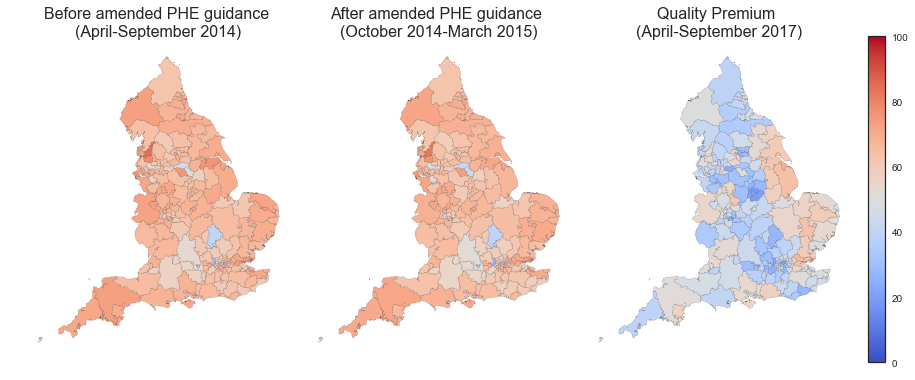

In [23]:
import geopandas as gpd
from matplotlib import verbose
# from our API https://openprescribing.net/api/1.0/org_location/?org_type=ccg
ccgs = gpd.read_file('ccgs.json').set_index('name')

ccgs = ccgs[~ccgs['geometry'].isnull()]  # remove ones without geometry - these are federations rather than individual CCGs
gdf_pre = ccgs.join(pre_map_data)
gdf_post = ccgs.join(post_map_data)
gdf_qp = ccgs.join(qp_map_data)

# set sort order of measures manually, and add grid refs to position each subplot:
s_pre = [(0,'trimethoprim_percent',0,0)]
s_post = [(1,'trimethoprim_percent',0,1)]
s_qp = [(2,'trimethoprim_percent',0,2)]

# set common value limits for colour scale
vmin, vmax = 0, 100

fig = plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(1,3, width_ratios=[4,4,5])  # grid layout for subplots

for i in s_post:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_post.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=False, cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    ax.set_title('After amended PHE guidance \n(October 2014-March 2015)', size=16)
    plt.axis('off')
for i in s_pre:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_pre.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=False, cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    ax.set_title("Before amended PHE guidance \n(April-September 2014)",size = 16)
    plt.axis('off')
for i in s_qp:
    ax = plt.subplot(gs[i[2], i[3]])  # position of subplot in grid using coordinates listed in s
    gdf_qp.plot(ax=ax,column=i[1],  edgecolor='black', linewidth=0.1, legend=True, cmap='coolwarm',vmin=vmin, vmax=vmax)
    ax.set_aspect(1.63)
    ax.set_title("Quality Premium \n(April-September 2017)",size = 16)
    plt.axis('off')
plt.subplots_adjust(wspace = 0.05,hspace = 0.05)
plt.savefig('Figure 3.png', format='png', dpi=300,bbox_inches='tight')

plt.show()

### Top 10 highest and lowest users

In [38]:
#obtain data for lowest 10 CCG prescribers of trimethoprim
lowest_10_percent_df = pd.read_gbq("""
SELECT
  month,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(lowest.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items))*100 AS lowest_10_trimeth_percent
FROM
  `ebmdatalab.richard.trimethoprim_data_lowest_10` AS lowest
WHERE
  month>='2014-01-01'
GROUP BY
  month
ORDER BY
  month
  """, projectid, dialect='standard')
lowest_10_percent_df.to_csv('lowest_10_percent_df.csv')

Requesting query... ok.
Job ID: job_K0RHr01W9CKxydf9zsrRE0l2TXnx
Query running...
Query done.
Cache hit.

Retrieving results...
Got 47 rows.

Total time taken 1.18 s.
Finished at 2018-06-01 11:26:16.


In [39]:
#obtain data for highest 10 CCG prescribers of trimethoprim
highest_10_percent_df = pd.read_gbq("""
SELECT
  month,
  IEEE_DIVIDE(SUM(
      CASE
        WHEN SUBSTR(highest.bnf_code,1,9)='0501080W0' THEN items
        ELSE 0 END), SUM(items))*100 AS highest_10_trimeth_percent
FROM
  `ebmdatalab.richard.trimethoprim_data_highest_10` AS highest
WHERE
  month>='2014-01-01'
GROUP BY
  month
ORDER BY
  month
  """, projectid, dialect='standard')
highest_10_percent_df.to_csv('highest_10_percent_df.csv')


Requesting query... ok.
Job ID: job_yDlOBFEOZPMGVFU-gtIsUg4E7n2W
Query running...
Query done.
Cache hit.

Retrieving results...
Got 47 rows.

Total time taken 1.24 s.
Finished at 2018-06-01 11:26:39.


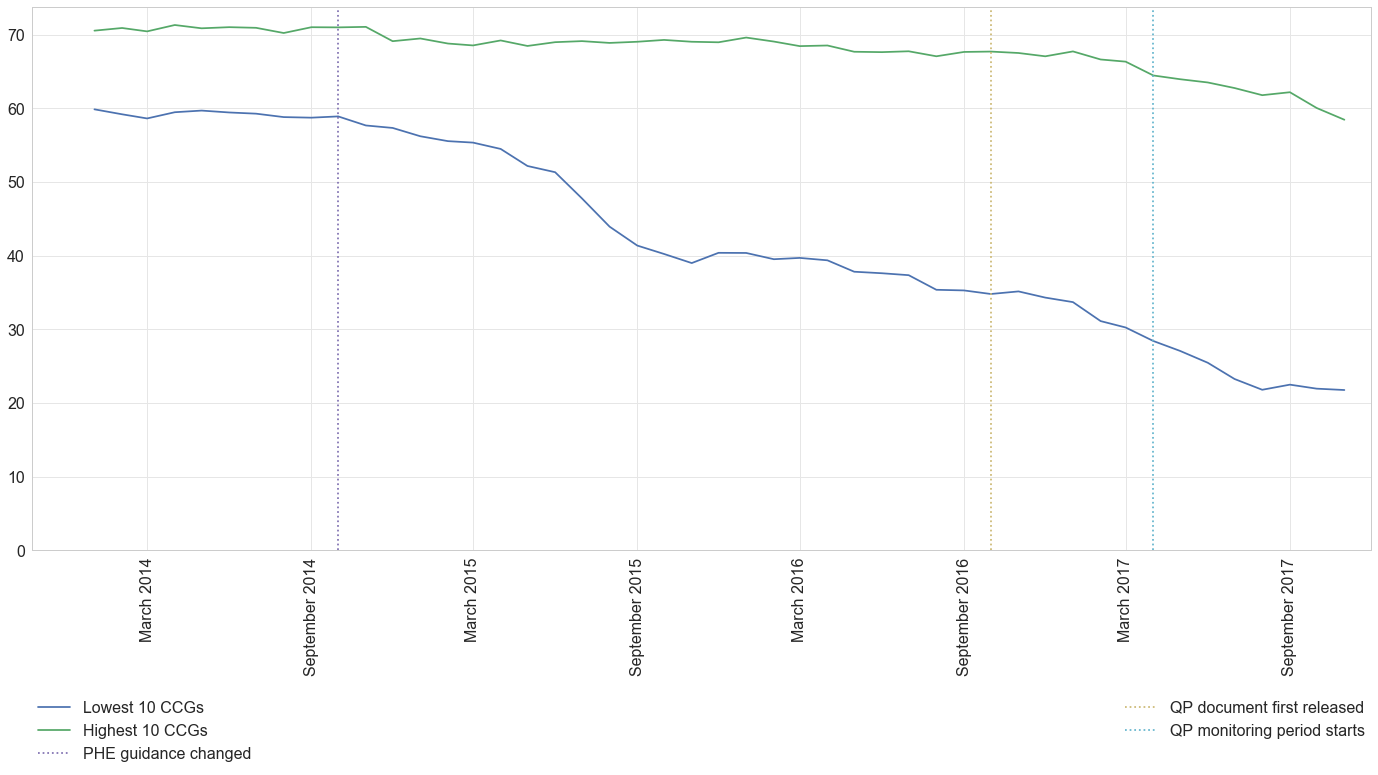

In [26]:
#plot data for both, and include vertical lines for key dates
sns.set_style("whitegrid",{'grid.color': '.9'})
fig = plt.figure(figsize=(6,6)) 
f, (ax1) = plt.subplots(1,1)
ax1.plot('month','lowest_10_trimeth_percent', data=lowest_10_percent_df, label='Lowest 10 CCGs')
ax1.plot('month','highest_10_trimeth_percent' , data=highest_10_percent_df, label='Highest 10 CCGs')
ax1.axvline(x='2014-10-01',label='PHE guidance changed', linestyle=':', color='C3')
ax1.axvline(x='2016-10-01',label='QP document first released', linestyle=':', color='C4')
ax1.axvline(x='2017-04-01',label='QP monitoring period starts', linestyle=':', color='C5')
ax1.set_ylim(ymin=0)
ax1.set_xlim(xmax='2017-12-01')
ax1.legend(bbox_to_anchor=(0., -.4, 1., .102), loc=8,
       ncol=2, mode="expand", fontsize=16, borderaxespad=0.)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)

ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%B %Y'))

plt.savefig('Figure 4.png', format='png', dpi=300,bbox_inches='tight')